# Portfolio Backtesting with Factor Investing and Potfolio Insurance Strategy
***for NATIXIS Investment Strategy Challenge***

*By GraapeInvestmentGroup*



## Table of Contents

1. [Introduction](#Introduction)
2. [Setup and Imports](#Setup)
3. [Data Loading](#Data_Loading)
4. [Factor Calculation](#Factor_Calculation)
5. [Strategy Backtest](#Strategy_Backtest)
6. [Performance Metrics](#Performance_Metrics)
7. [Visualizations](#Visualizations)
8. [Conclusion](#Conclusion)

---

<a id='Introduction'></a>
## Introduction

This notebook performs a backtest of a cryptocurrency focused portfolio using a **Factor Investing with Portfolio Insurance using SP**. The SP strategy dynamically adjusts the portfolio's hedge ratio based on the performance of long and short positions to mitigate potential losses, enhancing the traditional factor investing approach.

**Key Steps:**

1. **Setup and Imports**: Import necessary libraries.
2. **Data Loading**: Load historical price and market cap data for selected cryptocurrencies.
3. **Factor Calculation**: Compute Momentum, Size, and Value factors.
4. **Strategy Backtest**: Implement and backtest the Factor Investing with SP strategy.
5. **Performance Metrics**: Calculate Sharpe Ratio, Beta, and Alpha.
6. **Visualizations**: Plot portfolio performance, equity drawdowns, daily returns on assets, and portfolio holdings breakdown.
7. **Conclusion**: Summarize findings and potential next steps.

---

<a id='Setup'></a>
## Setup and Imports

First, we import all the required libraries for data manipulation, analysis, and visualization.


In [1682]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.api import OLS
import statsmodels.api as sm
import yfinance as yf

%matplotlib inline

<a id='Data_Loading'></a>
## Data Loading

We load historical price and market capitalization data for the top 10 cryptocurrencies (excluding USDT and USDC) from CSV files located in the Data folder. The data spans from October 1, 2021, to September 29, 2024.

In [1683]:
start_date = "2021-10-01"
end_date = "2024-09-29"
initial_investment = 100_000_000

top_10_coins = ['BTC', 'ETH', 'BNB', 'XRP', 'ADA', 'DOGE', 'SOL', 'TON', 'TRX', 'AVAX']
folder_path = 'Data'

def load_price_and_market_cap_data(folder_path, coins, start_date, end_date):
    price_data = {}
    market_cap_data = {}

    for coin in coins:
        file_path = os.path.join(folder_path, f"{coin}.csv")
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        df = pd.read_csv(file_path, parse_dates=['Start'], index_col='Start')
        price_data[coin] = df['Close']
        market_cap_data[coin] = df[['Market Cap', 'Volume']]

    price_data = pd.DataFrame(price_data)
    price_data.ffill(inplace=True)
    price_data.dropna(inplace=True)
    market_cap_data = {coin: df for coin, df in market_cap_data.items()}

    return price_data, market_cap_data

price_data, market_cap_data = load_price_and_market_cap_data(folder_path, top_10_coins, start_date, end_date)

print("Price Data Head:")
display(price_data.head())
display(market_cap_data['BTC'].head())


Price Data Head:


,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TON,TRX,AVAX
Start,,,,,,,,,,
2021-08-27,49005.9495,3268.2547,493.4016,1.174040,2.938407,0.293226,87.9080,0.781087,0.088081,50.0430
2021-08-28,48864.0249,3247.4221,486.2568,1.149294,2.855787,0.285629,97.2368,0.731698,0.088390,50.2641
2021-08-29,48876.7643,3236.1842,481.5356,1.144495,2.864885,0.282029,94.3016,0.553893,0.088654,47.5776
2021-08-30,47020.6765,3233.0987,462.3070,1.105831,2.739861,0.272074,109.8693,0.691245,0.086451,41.3548
2021-08-31,47225.2696,3441.6881,466.1393,1.191076,2.783445,0.278981,108.8281,0.744206,0.088930,39.6894


,Market Cap,Volume
Start,,
2024-09-30,1.265376e+12,9.631240e+10
2024-09-29,1.298645e+12,7.796129e+10
2024-09-28,1.299293e+12,9.322891e+10
2024-09-27,1.296411e+12,1.142918e+11
2024-09-26,1.270017e+12,1.037232e+11


We load historical price for 10 selected assets  from yfinance. The data spans from October 1, 2021, to September 29, 2024.

In [1684]:
import yfinance as yf
import pandas as pd

traditional_tickers = [
    'QQQ', 'VGT', 'XLK', 'GLD', 'SUSA', 'ESGU', 'IYT', 'VHT', 'VPU'
]

def load_traditional_assets(tickers, start_date, end_date):
    traditional_data = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        progress=False,
        interval='1d'
    )['Adj Close']
    
    if isinstance(traditional_data, pd.Series):
        traditional_data = traditional_data.to_frame()
    
    traditional_data.ffill(inplace=True)
    traditional_data.dropna(inplace=True)
    
    if traditional_data.index.tz is not None:
        traditional_data.index = traditional_data.index.tz_localize(None)
    
    return traditional_data

traditional_price_data = load_traditional_assets(traditional_tickers, start_date, end_date)

print("Traditional Assets Price Data Head:")
display(traditional_price_data.head())


Traditional Assets Price Data Head:


Ticker,ESGU,GLD,IYT,QQQ,SUSA,VGT,VHT,VPU,XLK
Date,,,,,,,,,
2021-10-01,95.337959,164.589996,59.835995,353.112091,93.102180,397.642456,237.497681,126.487114,147.754272
2021-10-04,94.054649,165.360001,59.597569,345.700409,91.921486,387.996155,233.796509,128.267960,144.332642
2021-10-05,95.041069,164.589996,60.353771,350.367096,92.852615,393.596313,234.860825,128.104401,146.389526
2021-10-06,95.481598,165.029999,60.864319,352.612152,93.207779,396.313354,234.506104,130.003448,147.344849
2021-10-07,96.286064,164.160004,60.777630,355.847351,93.985329,400.574524,237.344284,129.503662,148.690094


<a id='Factor_Calculation'></a>
<a id='Factor_Calculation'></a>
## Factor Calculation

We calculate three key factors for our strategy:

- **Momentum**: Measures the past week's return.
- **Size**: Represents the market capitalization of the cryptocurrencies.
- **Value**: Inverse of the NVT (Network Value to Transactions) ratio.

In [1685]:
def calculate_factors(price_data, cap_data, rolling_window=7):
    momentum = price_data.pct_change(rolling_window).shift(1)
    size = pd.DataFrame({coin: cap_data[coin]['Market Cap'] for coin in cap_data})
    value = pd.DataFrame({coin: cap_data[coin]['Market Cap'] / cap_data[coin]['Volume'] for coin in cap_data})
    value.replace([np.inf, -np.inf], np.nan, inplace=True)
    value.fillna(0, inplace=True)
    value = 1 / value
    value = value.clip(lower=-1e9, upper=1e9)
    return momentum, size, value

momentum, size, value = calculate_factors(price_data, market_cap_data)

print("Momentum Factor Tail:")
display(momentum.tail())

print("Size Factor Tail:")
display(size.tail())

print("Value Factor Tail:")
display(value.tail())


Momentum Factor Tail:


,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TON,TRX,AVAX
Start,,,,,,,,,,
2024-09-26,0.027933,0.092610,0.052105,-0.001943,0.114717,0.052270,0.111071,0.016833,0.003509,0.116487
2024-09-27,0.034757,0.066927,0.053832,0.004628,0.144953,0.127002,0.088826,0.019229,0.012564,0.094096
2024-09-28,0.042161,0.054506,0.070420,0.008669,0.144023,0.186249,0.078191,0.073023,0.020033,0.104889
2024-09-29,0.039976,0.024414,0.021169,0.028004,0.119095,0.172285,0.049205,0.039591,0.018837,0.056388
2024-09-30,0.032910,0.031044,0.014564,0.091827,0.130892,0.175206,0.095406,0.040979,0.030103,0.065746


Size Factor Tail:


,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TON,TRX,AVAX
Start,,,,,,,,,,
2024-09-26,1.270017e+12,3.157505e+11,8.775067e+10,3.319833e+10,1.416841e+10,1.664718e+10,7.159734e+10,1.468178e+10,1.317641e+10,1.149473e+10
2024-09-27,1.296411e+12,3.211482e+11,8.952743e+10,3.324678e+10,1.457472e+10,1.794640e+10,7.379332e+10,1.502069e+10,1.340329e+10,1.212090e+10
2024-09-28,1.299293e+12,3.224497e+11,8.907986e+10,3.436302e+10,1.414985e+10,1.846328e+10,7.376960e+10,1.502807e+10,1.341156e+10,1.204641e+10
2024-09-29,1.298645e+12,3.203801e+11,8.831945e+10,3.570950e+10,1.393878e+10,1.858525e+10,7.389539e+10,1.479591e+10,1.352095e+10,1.176477e+10
2024-09-30,1.265376e+12,3.152637e+11,8.513371e+10,3.583611e+10,1.346895e+10,1.758092e+10,7.321755e+10,1.474562e+10,1.350311e+10,1.152576e+10


Value Factor Tail:


,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TON,TRX,AVAX
Start,,,,,,,,,,
2024-09-26,0.081671,0.199373,0.090354,0.047386,0.036713,3.242736,0.171457,0.038988,0.047774,0.065963
2024-09-27,0.088160,0.205287,0.118976,0.054933,0.041338,3.124801,0.222105,0.046198,0.057976,0.077963
2024-09-28,0.071754,0.147764,0.115826,0.087055,0.030705,3.028710,0.159913,0.040417,0.050449,0.059558
2024-09-29,0.060033,0.097936,0.058895,0.112254,0.022930,3.000664,0.110558,0.027037,0.044975,0.043403
2024-09-30,0.076114,0.161215,0.089711,0.125774,0.032210,3.054248,0.168353,0.027875,0.055127,0.059829


## Factors Preview

In [1686]:
momentum.tail()
size.tail()
value.tail()

,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TON,TRX,AVAX
Start,,,,,,,,,,
2024-09-26,0.081671,0.199373,0.090354,0.047386,0.036713,3.242736,0.171457,0.038988,0.047774,0.065963
2024-09-27,0.088160,0.205287,0.118976,0.054933,0.041338,3.124801,0.222105,0.046198,0.057976,0.077963
2024-09-28,0.071754,0.147764,0.115826,0.087055,0.030705,3.028710,0.159913,0.040417,0.050449,0.059558
2024-09-29,0.060033,0.097936,0.058895,0.112254,0.022930,3.000664,0.110558,0.027037,0.044975,0.043403
2024-09-30,0.076114,0.161215,0.089711,0.125774,0.032210,3.054248,0.168353,0.027875,0.055127,0.059829


<a id='Strategy_Backtest'></a>
<a id='Strategy_Backtest'></a>
## Strategy Backtest

We implement the Factor Investing with Stop Protection (SP) Portfolio Inurance, which adjusts the portfolio's hedge ratio based on the relative performance of long and short positions to manage risk effectively.

### Strategy Functions
#### Adjust Hedge Ratio

In [1687]:
def adjust_hedge(long_return_total, short_return_average):
    if long_return_total < short_return_average:
        return 0.95  # Adjustable parameter
    else:
        return 0.0

#### Protection Strategy SP

In [1688]:
def protection_strategy_sp(weekly_return, long_return_total, short_return_average):
    hedge_ratio = adjust_hedge(long_return_total, short_return_average)
    adjusted_weekly_return = long_return_total * (1 - hedge_ratio) - short_return_average
    return adjusted_weekly_return

#### Rebalancing Function

In [1689]:
def rebalancing(portfolio, target_allocation):
    total_value = sum(portfolio.values())
    for asset, allocation in target_allocation.items():
        portfolio[asset] = total_value * allocation
    return portfolio

#### Functions for Tradional Assets

In [1690]:
def traditional_trading_strategy(price_data, lookback_period=63):
    short_ma = price_data.rolling(window=20).mean()
    long_ma = price_data.rolling(window=50).mean()
    signal = pd.DataFrame(0, index=price_data.index, columns=price_data.columns)
    signal[short_ma > long_ma] = 1
    signal[short_ma < long_ma] = -1
    return signal

def get_rebalance_dates(start_date, end_date, months_interval=3, weekday=0):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    dates = pd.date_range(start=start_date, end=end_date, freq=f'{months_interval}MS')
    adjusted_dates = []
    for date in dates:
        days_ahead = (weekday - date.weekday() + 7) % 7
        adjusted_date = date + pd.Timedelta(days=days_ahead)
        if adjusted_date <= end_date:
            adjusted_dates.append(adjusted_date)
    rebalance_dates = pd.DatetimeIndex(adjusted_dates)
    return rebalance_dates

rebalance_dates = get_rebalance_dates('2022-01-01', '2023-12-31', months_interval=3)
#print(rebalance_dates)

def rebalance_portfolio(current_portfolio_value, target_crypto_allocation, target_traditional_allocation):
    return target_crypto_allocation, target_traditional_allocation

def get_next_trading_day(trading_days, current_date):
    future_days = trading_days[trading_days > current_date]
    if not future_days.empty:
        return future_days[0]
    return None


#### Backtest Function

In [1691]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def backtest_strategy(
    start_date,
    end_date,
    initial_investment,
    crypto_price_data,
    market_cap_data,
    market_cap_df,
    traditional_price_data,
    protection_strategy,
    floor_ratio=0.9,
    multiplier=3,
    threshold=0.05,
    base_allocation_tipp=0.5,
    max_allocation_vbpi=1.0,
    min_allocation_vbpi=0.0,
    initial_crypto_allocation=0.5,
    initial_traditional_allocation=0.5,
    rebalance_frequency='3M'
):
    total_portfolio_value = initial_investment
    crypto_portfolio_value = initial_investment * initial_crypto_allocation
    traditional_portfolio_value = initial_investment * initial_traditional_allocation

    portfolio_history = []
    returns_history = []
    holdings_history = []

    crypto_portfolio_history = []
    traditional_portfolio_history = []
    crypto_returns_history = []
    traditional_returns_history = []
    individual_asset_history = []

    dates = pd.date_range(start=start_date, end=end_date, freq='W-MON')

    floor = initial_investment * floor_ratio

    months_interval = int(rebalance_frequency.rstrip('M'))

    rebalance_dates = get_rebalance_dates(start_date, end_date, months_interval=months_interval, weekday=0)

    rebalance_dates = rebalance_dates[(rebalance_dates >= dates[0]) & (rebalance_dates <= dates[-1])]

    momentum, size, value = calculate_factors(crypto_price_data, market_cap_data)

    scaler = StandardScaler()
    momentum_std = pd.DataFrame(scaler.fit_transform(momentum.fillna(0)),
                                index=momentum.index, columns=momentum.columns)
    size_std = pd.DataFrame(scaler.fit_transform(size.fillna(0)),
                            index=size.index, columns=size.columns)
    value_std = pd.DataFrame(scaler.fit_transform(value.fillna(0)),
                             index=value.index, columns=value.columns)

    combined_signal_crypto = (momentum_std + size_std + value_std) / 3
    combined_signal_crypto = combined_signal_crypto.loc[start_date:end_date]

    combined_signal_traditional = traditional_trading_strategy(traditional_price_data, lookback_period=63)
    combined_signal_traditional = combined_signal_traditional.loc[start_date:end_date]

    for current_date in dates:
        normalized_date = current_date.normalize()

        if normalized_date in rebalance_dates:
            total_portfolio_value = crypto_portfolio_value + traditional_portfolio_value
            crypto_portfolio_value = total_portfolio_value * initial_crypto_allocation
            traditional_portfolio_value = total_portfolio_value * initial_traditional_allocation

            floor = total_portfolio_value * floor_ratio

            print(f"Rebalancing on {normalized_date.date()}:")
            print(f"  Total Portfolio Value: {total_portfolio_value:.2f}")
            print(f"  Crypto Portfolio Value: {crypto_portfolio_value:.2f}")
            print(f"  Traditional Portfolio Value: {traditional_portfolio_value:.2f}")

        if normalized_date in combined_signal_crypto.index:
            signals = combined_signal_crypto.loc[normalized_date]

            if signals.isna().all():
                crypto_portfolio_history.append(crypto_portfolio_value)
                crypto_returns_history.append(0.0)
            else:
                long_threshold = 0.5
                short_threshold = -0.5

                long_coins = signals[signals > long_threshold].index
                short_coins = signals[signals < short_threshold].index

                if len(long_coins) > 0 and normalized_date in size.index:
                    total_market_cap = size.loc[normalized_date, long_coins].sum()
                    weights = size.loc[normalized_date, long_coins] / total_market_cap
                else:
                    weights = pd.Series(dtype=float)

                try:
                    future_dates = crypto_price_data.index[crypto_price_data.index > normalized_date]
                    if future_dates.empty:
                        crypto_portfolio_history.append(crypto_portfolio_value)
                        crypto_returns_history.append(0.0)
                        continue
                    next_date = future_dates[0]

                    long_return_total = 0.0
                    if len(long_coins) > 0:
                        long_price_current = crypto_price_data.loc[normalized_date, long_coins]
                        long_price_next = crypto_price_data.loc[next_date, long_coins]
                        long_returns = (long_price_next / long_price_current - 1) * weights
                        long_return_total = long_returns.sum()

                    short_return_total = 0.0
                    if len(short_coins) > 0:
                        short_price_current = crypto_price_data.loc[normalized_date, short_coins]
                        short_price_next = crypto_price_data.loc[next_date, short_coins]
                        short_returns = (short_price_current / short_price_next - 1)
                        short_return_total = short_returns.mean() if not short_returns.empty else 0.0

                except Exception as e:
                    crypto_portfolio_history.append(crypto_portfolio_value)
                    crypto_returns_history.append(0.0)
                    continue

                original_weekly_return = long_return_total - short_return_total

                if protection_strategy.__name__ == 'protection_strategy_vbpi': # can be implemented
                    adjusted_weekly_return = protection_strategy(
                        portfolio_value=crypto_portfolio_value,
                        floor=floor * initial_crypto_allocation,
                        multiplier=multiplier,
                        original_return=original_weekly_return
                    )
                else:
                    adjusted_weekly_return = protection_strategy(
                        weekly_return=original_weekly_return,
                        long_return_total=long_return_total,
                        short_return_average=short_return_total
                    )

                crypto_portfolio_value *= (1 + adjusted_weekly_return)

                crypto_portfolio_history.append(crypto_portfolio_value)
                crypto_returns_history.append(adjusted_weekly_return)
        else:
            crypto_portfolio_history.append(crypto_portfolio_value)
            crypto_returns_history.append(0.0)

        if normalized_date in combined_signal_traditional.index:
            traditional_signals = combined_signal_traditional.loc[normalized_date]

            long_threshold_trad = 0
            short_threshold_trad = 0
            long_tickers = traditional_signals[traditional_signals > long_threshold_trad].index
            short_tickers = traditional_signals[traditional_signals < short_threshold_trad].index

            weights_long_trad = pd.Series(1 / len(long_tickers), index=long_tickers) if len(long_tickers) > 0 else pd.Series(dtype=float)
            weights_short_trad = pd.Series(1 / len(short_tickers), index=short_tickers) if len(short_tickers) > 0 else pd.Series(dtype=float)

            try:
                future_dates = traditional_price_data.index[traditional_price_data.index > normalized_date]
                if future_dates.empty:
                    traditional_portfolio_history.append(traditional_portfolio_value)
                    traditional_returns_history.append(0.0)
                    continue
                next_date = future_dates[0]

                long_return_total_trad = 0.0
                if len(long_tickers) > 0:
                    price_current_long_trad = traditional_price_data.loc[normalized_date, long_tickers]
                    price_future_long_trad = traditional_price_data.loc[next_date, long_tickers]
                    trad_returns_long = (price_future_long_trad / price_current_long_trad - 1) * weights_long_trad
                    long_return_total_trad = trad_returns_long.sum()

                short_return_total_trad = 0.0
                if len(short_tickers) > 0:
                    price_current_short_trad = traditional_price_data.loc[normalized_date, short_tickers]
                    price_future_short_trad = traditional_price_data.loc[next_date, short_tickers]
                    short_returns_trad = (price_current_short_trad / price_future_short_trad - 1) * weights_short_trad
                    short_return_total_trad = short_returns_trad.sum()

                traditional_return = long_return_total_trad + short_return_total_trad

            except Exception as e:
                traditional_portfolio_history.append(traditional_portfolio_value)
                traditional_returns_history.append(0.0)
                continue

            traditional_portfolio_value *= (1 + traditional_return)

            traditional_portfolio_history.append(traditional_portfolio_value)
            traditional_returns_history.append(traditional_return)
        else:
            traditional_portfolio_history.append(traditional_portfolio_value)
            traditional_returns_history.append(0.0)

        total_portfolio_value = crypto_portfolio_value + traditional_portfolio_value
        portfolio_history.append(total_portfolio_value)

        if len(portfolio_history) > 1:
            total_return = (portfolio_history[-1] / portfolio_history[-2]) - 1
        else:
            total_return = 0.0
        returns_history.append(total_return)

        holdings = {
            'Crypto Allocation': crypto_portfolio_value / total_portfolio_value,
            'Traditional Allocation': traditional_portfolio_value / total_portfolio_value
        }
        holdings_history.append(holdings)
        crypto_allocations = {}
        if len(long_coins) > 0:
            for coin in long_coins:
                crypto_allocations[f"{coin}_long"] = weights.get(coin, 0) * crypto_portfolio_value / total_portfolio_value
        if len(short_coins) > 0:
            short_weights = pd.Series(1 / len(short_coins), index=short_coins)  # Equal weight for short positions
            for coin in short_coins:
                crypto_allocations[f"{coin}_short"] = -short_weights.get(coin, 0) * crypto_portfolio_value / total_portfolio_value

        # Track individual traditional asset allocations
        traditional_allocations = {}
        if len(long_tickers) > 0:
            for ticker in long_tickers:
                traditional_allocations[f"{ticker}_long"] = weights_long_trad.get(ticker, 0) * traditional_portfolio_value / total_portfolio_value
        if len(short_tickers) > 0:
            for ticker in short_tickers:
                traditional_allocations[f"{ticker}_short"] = -weights_short_trad.get(ticker, 0) * traditional_portfolio_value / total_portfolio_value

        # Combine allocations
        all_allocations = {**crypto_allocations, **traditional_allocations}
        individual_asset_history.append(all_allocations)

    portfolio_history_df = pd.DataFrame(portfolio_history, index=dates, columns=['Portfolio Value'])
    holdings_history_df = pd.DataFrame(holdings_history, index=dates)
    individual_asset_history_df = pd.DataFrame(individual_asset_history, index=dates)

    crypto_portfolio_history_df = pd.DataFrame(crypto_portfolio_history, index=dates, columns=['Crypto Portfolio Value'])
    traditional_portfolio_history_df = pd.DataFrame(traditional_portfolio_history, index=dates, columns=['Traditional Portfolio Value'])

    crypto_cumulative_return = (crypto_portfolio_history_df['Crypto Portfolio Value'].iloc[-1] / crypto_portfolio_history_df['Crypto Portfolio Value'].iloc[0]) - 1
    traditional_cumulative_return = (traditional_portfolio_history_df['Traditional Portfolio Value'].iloc[-1] / traditional_portfolio_history_df['Traditional Portfolio Value'].iloc[0]) - 1

    print(f"Crypto Cumulative Return: {crypto_cumulative_return:.2%}")
    print(f"Traditional Assets Cumulative Return: {traditional_cumulative_return:.2%}")

    return portfolio_history_df, returns_history, holdings_history_df, individual_asset_history_df


#### Running the Backtest

In [1692]:
protection_strategy = protection_strategy_sp

floor_ratio = 0.9
multiplier = 3
threshold = 0.05
base_allocation_tipp = 0.5
max_allocation_vbpi = 1.0
min_allocation_vbpi = 0.0

market_cap_df = pd.DataFrame({coin: df['Market Cap'] for coin, df in market_cap_data.items()})

print("Market Cap DataFrame Head:")
display(market_cap_df.head())

portfolio_history, returns_history, holdings_history, individual_asset_history = backtest_strategy(
    start_date=start_date, 
    end_date=end_date, 
    initial_investment=initial_investment, 
    crypto_price_data=price_data,
    market_cap_data=market_cap_data,
    market_cap_df=market_cap_df,
    traditional_price_data=traditional_price_data,
    protection_strategy=protection_strategy_sp,
    multiplier=multiplier,
    threshold=threshold,
    base_allocation_tipp=base_allocation_tipp,
    max_allocation_vbpi=max_allocation_vbpi,
    min_allocation_vbpi=min_allocation_vbpi,
    initial_crypto_allocation=0.5,
    initial_traditional_allocation=0.5,
    rebalance_frequency='3M'
)


Market Cap DataFrame Head:


,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TON,TRX,AVAX
Start,,,,,,,,,,
2018-01-01,2.292229e+11,7.311417e+10,0.0,8.706376e+10,1.814591e+10,9.701365e+08,NaN,NaN,3.049863e+09,NaN
2018-01-02,2.345984e+11,8.436733e+10,0.0,9.037632e+10,1.940001e+10,1.026499e+09,NaN,NaN,4.302503e+09,NaN
2018-01-03,2.538832e+11,8.749899e+10,0.0,1.085968e+11,2.529529e+10,1.014908e+09,NaN,NaN,5.207058e+09,NaN
2018-01-04,2.510367e+11,9.300369e+10,0.0,1.373512e+11,3.150835e+10,1.054012e+09,NaN,NaN,1.067987e+10,NaN
2018-01-05,2.718434e+11,9.791364e+10,0.0,1.283867e+11,2.876060e+10,1.196150e+09,NaN,NaN,1.496927e+10,NaN


Rebalancing on 2021-10-04:
  Total Portfolio Value: 100000000.00
  Crypto Portfolio Value: 50000000.00
  Traditional Portfolio Value: 50000000.00
Rebalancing on 2022-01-03:
  Total Portfolio Value: 115685107.75
  Crypto Portfolio Value: 57842553.87
  Traditional Portfolio Value: 57842553.87
Rebalancing on 2022-04-04:
  Total Portfolio Value: 141891081.33
  Crypto Portfolio Value: 70945540.66
  Traditional Portfolio Value: 70945540.66
Rebalancing on 2022-07-04:
  Total Portfolio Value: 157018946.69
  Crypto Portfolio Value: 78509473.35
  Traditional Portfolio Value: 78509473.35
Rebalancing on 2022-10-03:
  Total Portfolio Value: 143842804.97
  Crypto Portfolio Value: 71921402.48
  Traditional Portfolio Value: 71921402.48
Rebalancing on 2023-01-02:
  Total Portfolio Value: 137760419.18
  Crypto Portfolio Value: 68880209.59
  Traditional Portfolio Value: 68880209.59
Rebalancing on 2023-04-03:
  Total Portfolio Value: 148078769.42
  Crypto Portfolio Value: 74039384.71
  Traditional Portfol

#### Portfolio History Preview

In [1693]:
print("Portfolio History Head:")
display(portfolio_history.head())

Portfolio History Head:


,Portfolio Value
2021-10-04,1.019815e+08
2021-10-11,1.019182e+08
2021-10-18,1.036114e+08
2021-10-25,1.035227e+08
2021-11-01,1.059018e+08


#### Portfolio Holdings Preview

In [1694]:
print("Holdings History Head:")
display(holdings_history.head())

Holdings History Head:


,Crypto Allocation,Traditional Allocation
2021-10-04,0.509715,0.490285
2021-10-11,0.509410,0.490590
2021-10-18,0.517428,0.482572
2021-10-25,0.517014,0.482986
2021-11-01,0.527864,0.472136


<a id='Performance_Metrics'></a>
<a id='Performance_Metrics'></a>
## Performance Metrics

We evaluate the backtested portfolio using the following metrics:

- **CAGR (Compound Annual Growth Rate)**: The annual growth rate of an investment assuming profits are reinvested.
- **Annualized Sharpe Ratio**: Measures risk-adjusted return by comparing excess return to portfolio volatility.
- **Beta**: Indicates the portfolio's volatility relative to S&P500.
- **Alpha (Annualized)**: Represents the portfolio's performance relative to the expected return based on its Beta.
- **Sortino Ratio**: Focuses on downside risk by measuring excess return against downside volatility.
- **Volatility (Annualized)**: Measures the variation in portfolio returns, expressed as a percentage.
- **Maximum Drawdown**: The largest peak-to-trough decline in portfolio value over time.
- **Calmar Ratio**: Ratio of annualized return to maximum drawdown, assessing return relative to risk.

### Performance Metrics Function

In [1695]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm

def calculate_metrics(portfolio_history, returns_history, start_date, end_date):
    backtest_dates = pd.date_range(start=start_date, end=end_date, freq='W-MON')

    if len(returns_history) < len(backtest_dates):
        backtest_dates = backtest_dates[:len(returns_history)]
    elif len(returns_history) > len(backtest_dates):
        returns_history = returns_history[:len(backtest_dates)]

    returns_series = pd.Series(returns_history, index=backtest_dates)
    common_dates = portfolio_history.index.intersection(backtest_dates)
    portfolio_history = portfolio_history.loc[common_dates]
    returns_series = returns_series.loc[common_dates]

    if portfolio_history.empty:
        print("Error: Portfolio history is empty after aligning with backtest dates.")
        return {}

    portfolio_values = portfolio_history['Portfolio Value']

    if portfolio_values.empty:
        print("Error: Portfolio values are empty.")
        return {}

    num_years = (portfolio_values.index[-1] - portfolio_values.index[0]).days / 365.25
    ending_value = portfolio_values.iloc[-1]
    beginning_value = portfolio_values.iloc[0]
    cagr = (ending_value / beginning_value) ** (1 / num_years) - 1
    annualized_sharpe = (returns_series.mean() / returns_series.std()) * np.sqrt(52)

    sp500_ticker = '^GSPC'
    try:
        sp500_data = yf.download(sp500_ticker, start=start_date, end=end_date, progress=False)
    except Exception as e:
        print(f"Error fetching S&P 500 data: {e}")
        return {}

    if sp500_data.empty:
        print("Fetched S&P 500 data is empty. Please check the ticker and date range.")
        return {}

    sp500_data.sort_index(inplace=True)
    sp500_returns_daily = sp500_data['Close'].pct_change().dropna()
    sp500_returns_weekly = sp500_returns_daily.resample('W-MON').agg(lambda x: (1 + x).prod() - 1)
    common_dates = returns_series.index.intersection(sp500_returns_weekly.index)
    aligned_portfolio_returns = returns_series.loc[common_dates]
    aligned_sp500_returns = sp500_returns_weekly.loc[common_dates]
    aligned_portfolio_returns = aligned_portfolio_returns.dropna()
    aligned_sp500_returns = aligned_sp500_returns.dropna()
    common_dates_final = aligned_portfolio_returns.index.intersection(aligned_sp500_returns.index)
    aligned_portfolio_returns = aligned_portfolio_returns.loc[common_dates_final]
    aligned_sp500_returns = aligned_sp500_returns.loc[common_dates_final]

    if len(aligned_portfolio_returns) < 2:
        print("Not enough data for regression.")
        return {}

    annualized_volatility = aligned_portfolio_returns.std() * np.sqrt(52)
    X = sm.add_constant(aligned_sp500_returns)
    model = sm.OLS(aligned_portfolio_returns, X).fit()
    beta = model.params[aligned_sp500_returns.name]
    alpha = model.params['const']
    annualized_alpha = alpha * 52
    downside_returns = aligned_portfolio_returns[aligned_portfolio_returns < 0]
    downside_std = np.sqrt((downside_returns ** 2).mean()) * np.sqrt(52)
    sortino_ratio = (aligned_portfolio_returns.mean() * 52) / downside_std if downside_std != 0 else np.nan
    cumulative_returns = (1 + aligned_portfolio_returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdowns = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()
    calmar_ratio = (cagr) / abs(max_drawdown) if max_drawdown != 0 else np.nan

    metrics = {
        'CAGR': cagr,
        'Annualized Sharpe Ratio': annualized_sharpe,
        'Beta': beta,
        'Alpha (Annualized)': annualized_alpha,
        'Sortino Ratio': sortino_ratio,
        'Volatility (Annualized)': annualized_volatility,
        'Maximum Drawdown': max_drawdown,
        'Calmar Ratio': calmar_ratio
    }

    return metrics


#### Calculating Metrics

In [1696]:

metrics = calculate_metrics(portfolio_history, returns_history, start_date, end_date)
for key, value in metrics.items():
    if 'Ratio' in key or 'CAGR' in key or 'Alpha' in key or 'Beta' in key:
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value:.4%}")
        


CAGR: 0.2474
Annualized Sharpe Ratio: 1.9536
Beta: -0.0816
Alpha (Annualized): 0.2345
Sortino Ratio: 2.4406
Volatility (Annualized): 11.5641%
Maximum Drawdown: -17.9257%
Calmar Ratio: 1.3800


<a id='Visualizations'></a>
<a id='Visualizations'></a>
## Visualizations

To better understand the portfolio performance, we include various plots:

1. **Portfolio Value Over Time**
2. **Equity Drawdown Over Time**
3. **Daily Returns on Assets**
4. **Portfolio Holdings Breakdown Over Time**

### 1. Portfolio Value Over Time

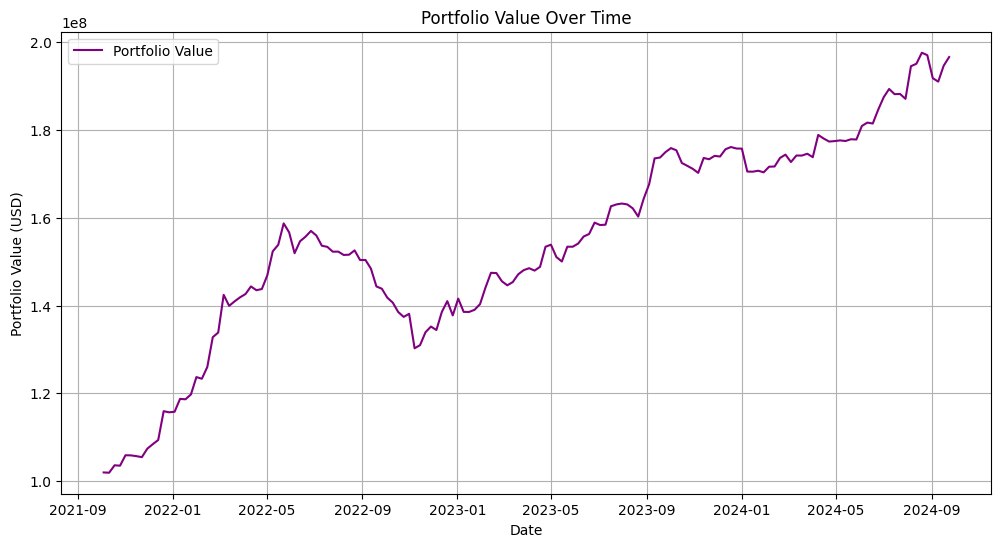

In [1697]:
def plot_portfolio(portfolio_history):
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_history.index, portfolio_history['Portfolio Value'], label='Portfolio Value', color='purple')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_portfolio(portfolio_history)

### 2. Equity Drawdown

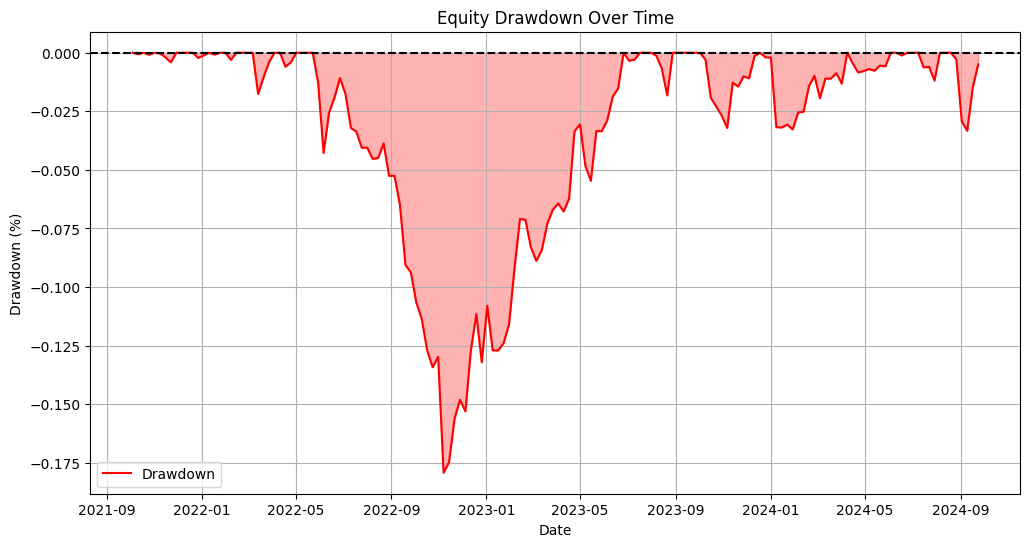

In [1698]:
def plot_equity_drawdown(portfolio_history):
    portfolio_history['Max Value'] = portfolio_history['Portfolio Value'].cummax()
    portfolio_history['Drawdown'] = (portfolio_history['Portfolio Value'] - portfolio_history['Max Value']) / portfolio_history['Max Value']

    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_history.index, portfolio_history['Drawdown'], label='Drawdown', color='red')
    plt.fill_between(portfolio_history.index, portfolio_history['Drawdown'], color='red', alpha=0.3)
    plt.title('Equity Drawdown Over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown (%)')
    plt.axhline(0, color='black', linestyle='--')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_equity_drawdown(portfolio_history)

### 3. Daily Returns on Assets

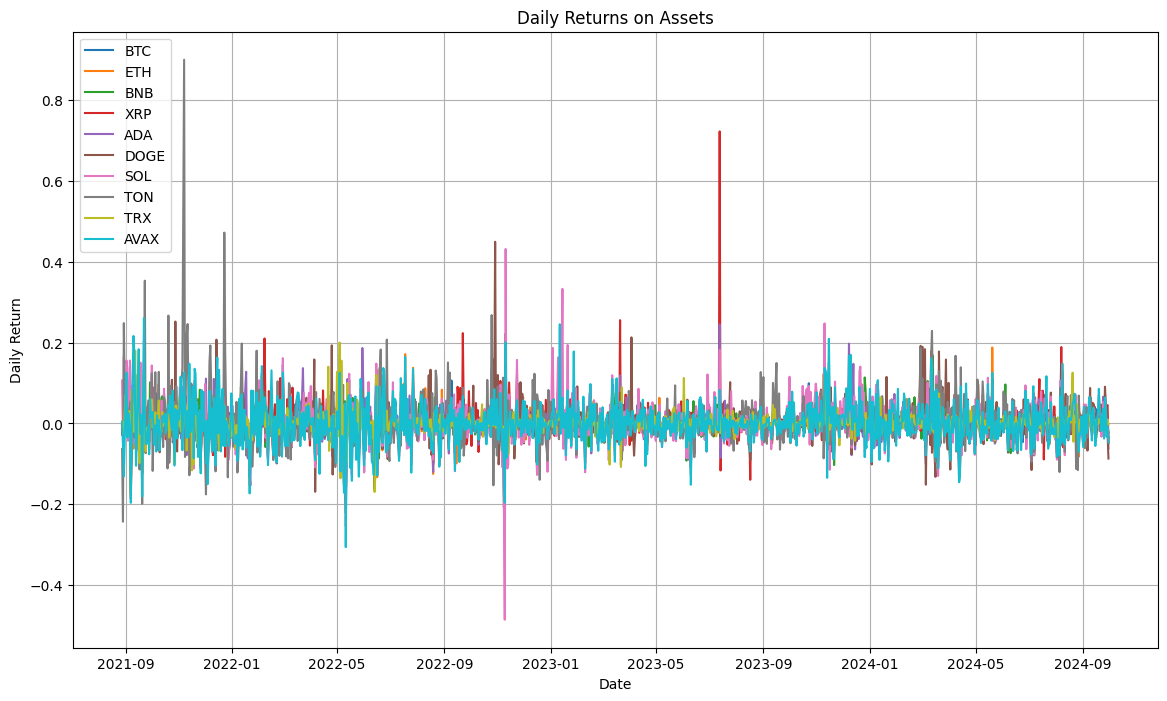

In [1699]:
def plot_daily_returns_on_assets(price_data):
    daily_returns = price_data.pct_change().dropna()  # Calculate daily returns
    plt.figure(figsize=(14, 8))
    for column in daily_returns.columns:
        plt.plot(daily_returns.index, daily_returns[column], label=column)
    plt.title('Daily Returns on Assets')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

plot_daily_returns_on_assets(price_data)

### 4. Portfolio Holdings Breakdown Over Time
To visualize how the portfolio's holdings in each cryptocurrency change over time, we use a stacked area chart. This provides insights into the allocation dynamics driven by the Factor Investing with SP strategy.

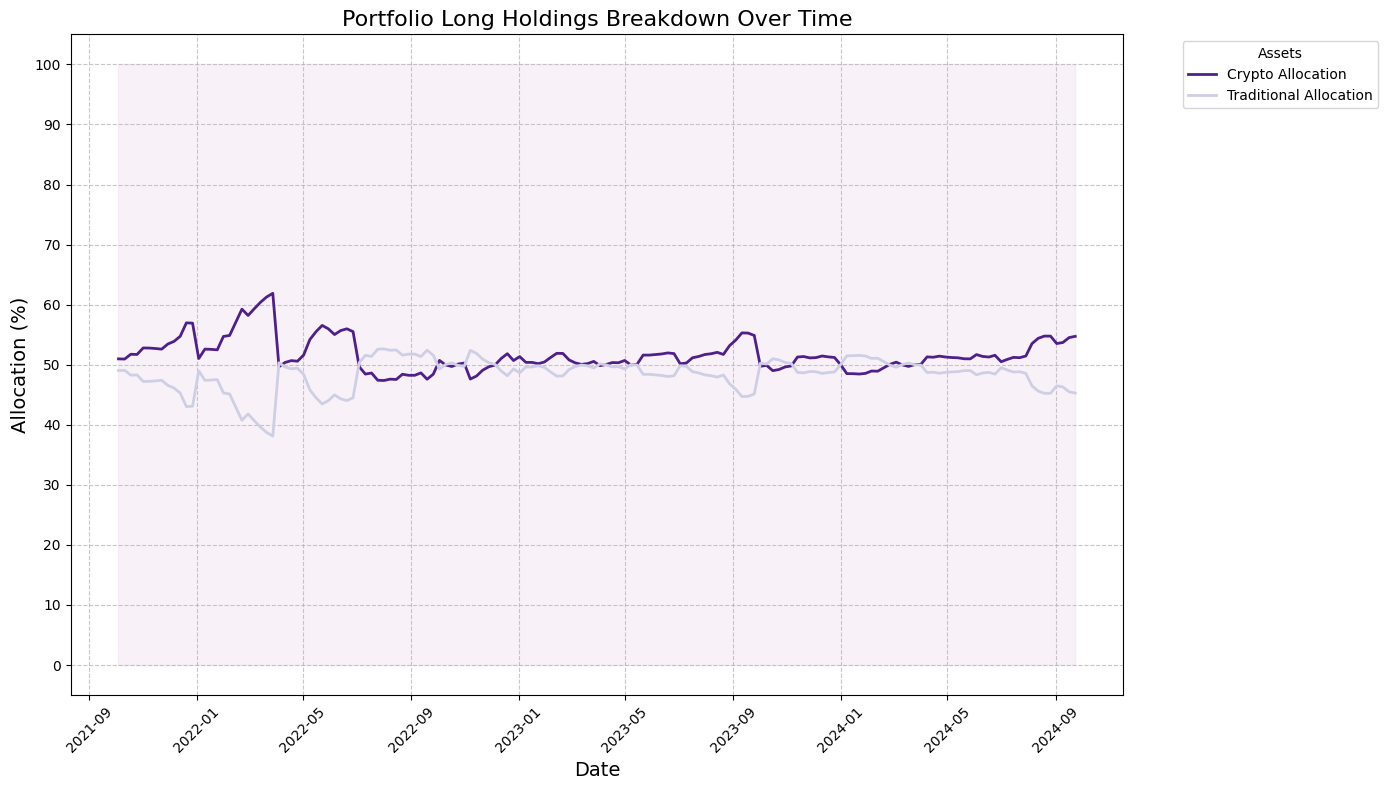

In [1700]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_portfolio_holdings(holdings_history_df):
    assets = holdings_history_df.clip(lower=0)
    num_assets = holdings_history_df.columns.nunique()
    shades_of_purple = [plt.cm.Purples(i) for i in np.linspace(0.3, 0.9, num_assets)]
    color_dict = dict(zip(holdings_history_df.columns, shades_of_purple))

    if assets.sum().sum() > 0:
        plt.figure(figsize=(14, 8))
        asset_names = list(assets.columns)
        plt.plot(assets.index, assets[asset_names[0]] * 100, label=asset_names[0], color=color_dict[asset_names[1]], linewidth=2)
        plt.plot(assets.index, assets[asset_names[1]] * 100, label=asset_names[1], color=color_dict[asset_names[0]], linewidth=2)
        for asset in asset_names[2:]:
            plt.plot(assets.index, assets[asset] * 100, label=asset, color=color_dict[asset], linewidth=2)
        plt.fill_between(assets.index, 0, assets.sum(axis=1) * 100, color='purple', alpha=0.05)
        plt.title('Portfolio Long Holdings Breakdown Over Time', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Allocation (%)', fontsize=14)
        plt.yticks(np.arange(0, 101, 10))
        plt.legend(title='Assets', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Example call to the function
plot_portfolio_holdings(holdings_history)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_34752\1415101260.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = cm.get_cmap('tab20', num_assets)


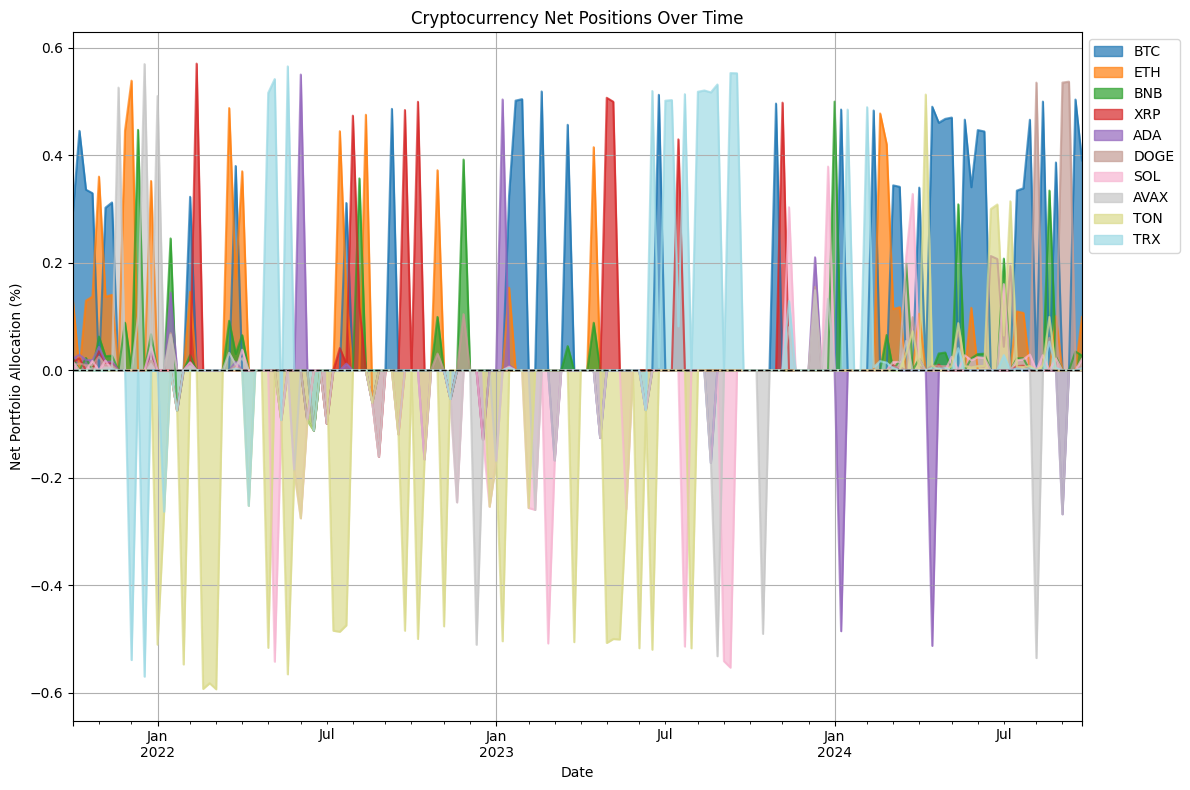

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_34752\1415101260.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = cm.get_cmap('tab20', num_assets)


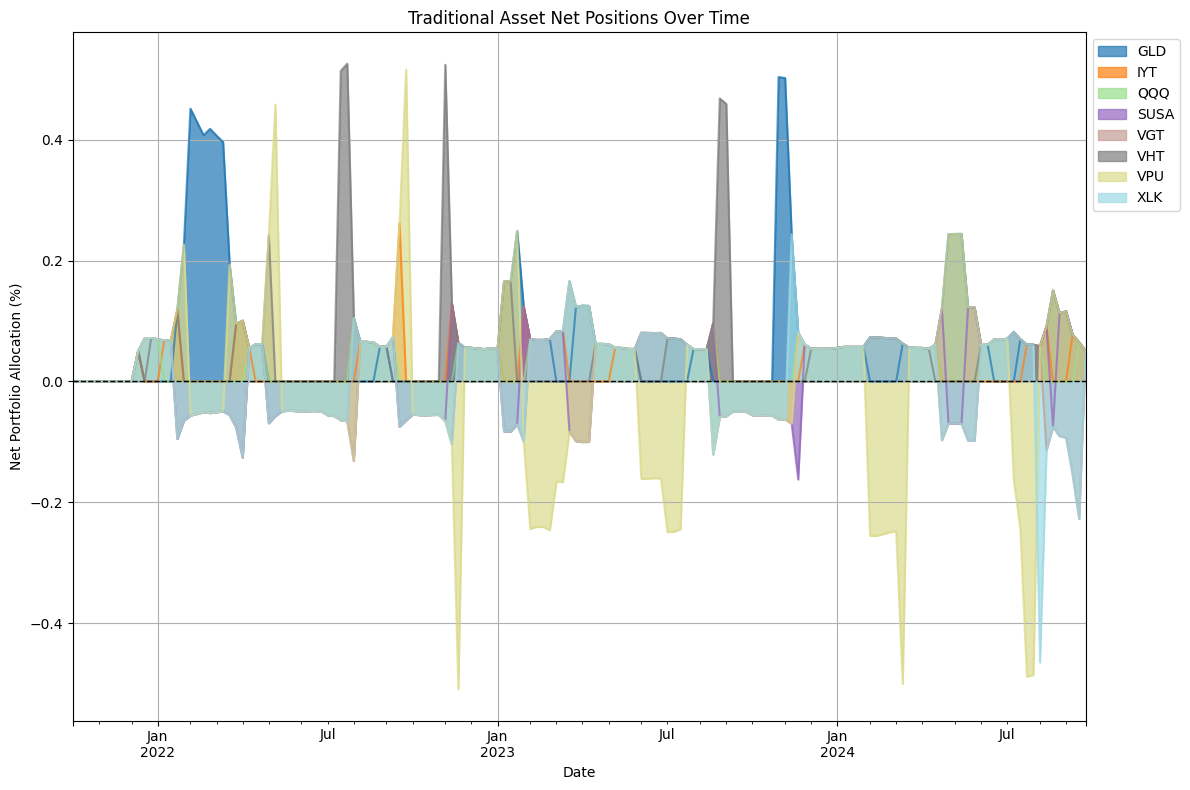

In [1701]:

crypto_long_columns = ['BTC_long', 'ETH_long', 'BNB_long', 'XRP_long', 'ADA_long', 'DOGE_long', 'SOL_long', 'AVAX_long', 'TON_long', 'TRX_long']
crypto_short_columns = ['BTC_short', 'ETH_short', 'BNB_short', 'XRP_short', 'ADA_short', 'DOGE_short', 'SOL_short', 'AVAX_short', 'TON_short', 'TRX_short']
traditional_long_columns = ['SUSA_long', 'VGT_long', 'XLK_long', 'GLD_long', 'QQQ_long', 'IYT_long', 'VHT_long', 'VPU_long']
traditional_short_columns = ['SUSA_short', 'VGT_short', 'XLK_short', 'VPU_short']

def calculate_net_positions(long_columns, short_columns):
    long_positions = individual_asset_history[long_columns]
    short_positions = individual_asset_history[short_columns]
    long_positions.columns = [col.replace('_long', '') for col in long_positions.columns]
    short_positions.columns = [col.replace('_short', '') for col in short_positions.columns]
    net_positions = long_positions.add(short_positions, fill_value=0)
    return net_positions

crypto_net_positions = calculate_net_positions(crypto_long_columns, crypto_short_columns)
traditional_net_positions = calculate_net_positions(traditional_long_columns, traditional_short_columns)

def plot_net_positions(net_positions, title):
    num_assets = net_positions.shape[1]
    color_palette = cm.get_cmap('tab20', num_assets)
    colors = [color_palette(i) for i in range(num_assets)]
    plt.figure(figsize=(12, 8))
    net_positions.plot(kind='area', stacked=False, alpha=0.7, color=colors, ax=plt.gca())
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Net Portfolio Allocation (%)')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_net_positions(crypto_net_positions, 'Cryptocurrency Net Positions Over Time')
plot_net_positions(traditional_net_positions, 'Traditional Asset Net Positions Over Time')


### 5. Plotting Portfolio vs. S&P 500

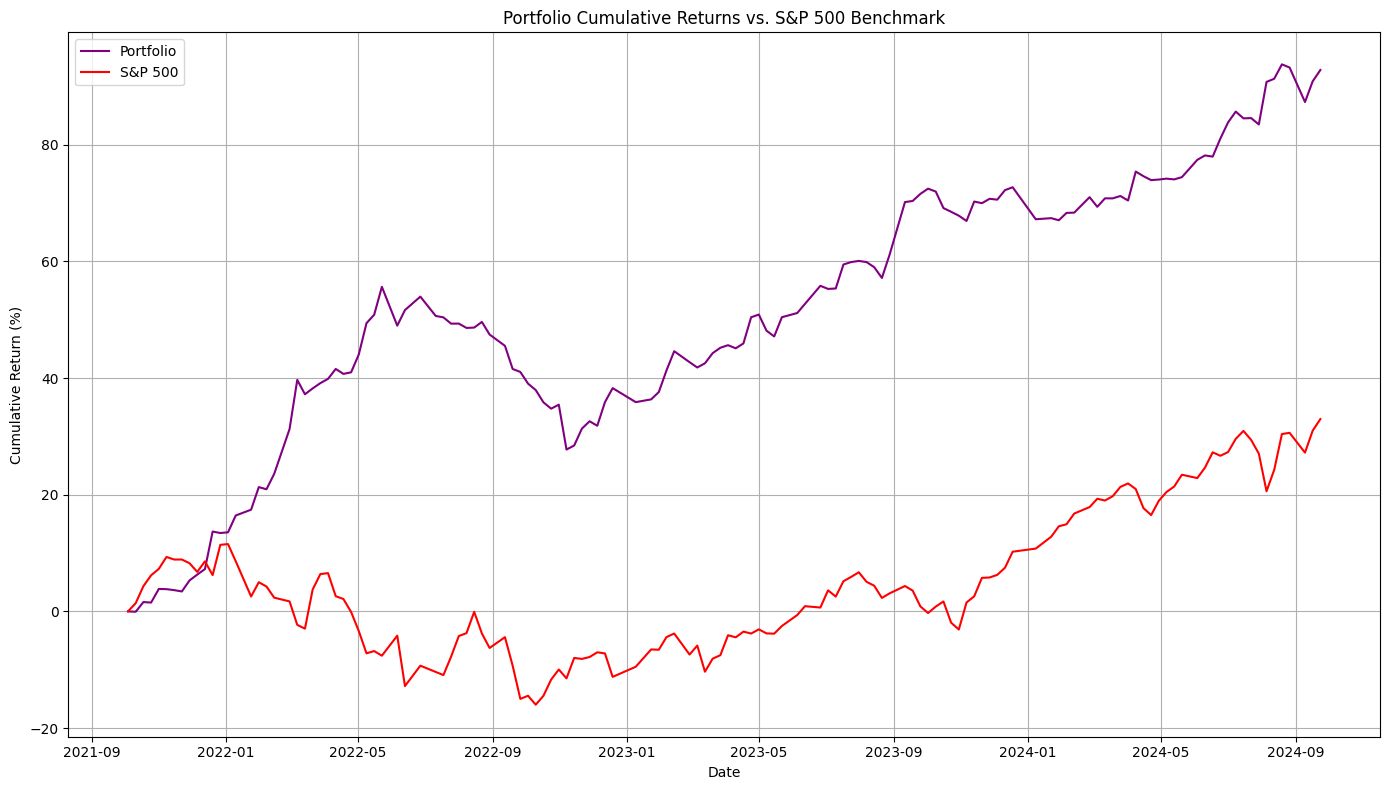

In [1702]:
portfolio_history = portfolio_history.resample('W-MON').ffill()
sp500_ticker = '^GSPC'
try:
    sp500_data = yf.download(sp500_ticker, start=start_date, end=end_date, progress=False)
except Exception as e:
    print(f"Error fetching S&P 500 data: {e}")

sp500_data = sp500_data.resample('W-MON').ffill()
combined_dates = portfolio_history.index.intersection(sp500_data.index)
portfolio_history = portfolio_history.loc[combined_dates]
sp500_data = sp500_data.loc[combined_dates]
portfolio_history.dropna(inplace=True)
sp500_data.dropna(inplace=True)

def fetch_benchmark_data(start_date, end_date):
    sp500_ticker = '^GSPC'
    try:
        sp500 = yf.download(sp500_ticker, start=start_date, end=end_date, progress=False)
    except Exception as e:
        print(f"Error fetching S&P 500 data: {e}")
        return pd.Series()
    
    if sp500.empty:
        print("Fetched S&P 500 data is empty. Please check the ticker and date range.")
        return pd.Series()
    
    sp500 = sp500['Close']
    sp500 = sp500.ffill().dropna()
    return sp500

sp500_data = fetch_benchmark_data(start_date, end_date)
#print("S&P 500 Data Head:")
#display(sp500_data.head())

def plot_portfolio_vs_benchmark(portfolio_history, sp500_data):
    combined_dates = portfolio_history.index.intersection(sp500_data.index)
    portfolio_values = portfolio_history.loc[combined_dates, 'Portfolio Value']
    sp500_prices = sp500_data.loc[combined_dates]
    
    portfolio_cum_returns = (portfolio_values / portfolio_values.iloc[0]) - 1
    sp500_cum_returns = (sp500_prices / sp500_prices.iloc[0]) - 1
    
    cum_returns_df = pd.DataFrame({
        'Portfolio': portfolio_cum_returns,
        'S&P 500': sp500_cum_returns
    }, index=combined_dates)
    
    plt.figure(figsize=(14, 8))
    plt.plot(cum_returns_df.index, cum_returns_df['Portfolio'] * 100, label='Portfolio', color='purple') 
    plt.plot(cum_returns_df.index, cum_returns_df['S&P 500'] * 100, label='S&P 500', color='red') 
    plt.title('Portfolio Cumulative Returns vs. S&P 500 Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_portfolio_vs_benchmark(portfolio_history, sp500_data)


<a id='Conclusion'></a>
## Conclusion

In this notebook, we implemented and backtested a Factor Investing with Pofolio Insurance using SP strategy for a cryptocurrency focused portfolio. The SP strategy dynamically adjusts the hedge ratio based on the performance of long and short positions to manage risk effectively, complementing traditional factor investing principles.

### Key Takeaways:
- **Dynamic Hedging**: The SP strategy adjusts the portfolio's exposure based on market conditions, potentially reducing losses during downturns.
- **Factor Integration**: Incorporating Momentum, Size, and Value factors enhances the selection and weighting of assets in the portfolio.
- **Rebalancing**: Rebalancing back to intitial asset divison improves perfromance by decreasing risk.


### Improvemnts:
- **Parameter Tuning**: Experiment with different hedge ratios, thresholds, and factor combinations to optimize performance.
- **Portfolio Insurance**: Try other portflio insurance strategies like CPPI,TIPP,and VBPIcto see if it perform better.
- **Additional Factors**: Incorporate other factors such as volatility, liquidity, or sentiment for a more comprehensive strategy.
- **Risk Management**: Implement advanced risk management techniques like Value at Risk (VaR) or Conditional Value at Risk (CVaR) to further safeguard the portfolio.
- **Derviatives**: Use combination of crypto derivatives like options and perpetual to hedge or increase return for the strategy
- **Broader Asset Selection**: Extend the analysis to include more cryptocurrencies or other tradional asset classes for diversification.
- **Real-Time Backtesting**: Integrate real-time data feeds to simulate live trading conditions.